In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, probplot
import numpy as np

In [6]:
import mysql.connector
from mysql.connector import Error
data = pd.read_csv('heart_disease.csv')

In [ ]:
mysql_config = {
    'host': 'my-mysql',  # Docker container name
    'user': 'root',
    'password': 'root',
    'database': 'mydb',
    'port': 3306,
}

# Connect to MySQL
try:
    connection = mysql.connector.connect(**mysql_config)
    with connection.cursor() as cursor:

        # SQL query to drop the table
        drop_table_query = "DROP TABLE IF EXISTS heartDisease"
        
        # Execute the drop table query
        cursor.execute(drop_table_query)
        
        # Commit the changes
        connection.commit()



        # Create table schema based on CSV columns
        create_table_query = """
        CREATE TABLE IF NOT EXISTS heartDisease (
            id INT AUTO_INCREMENT PRIMARY KEY,
            age INT,
            sex INT,
            painloc INT,
            painexer INT,
            relrest INT,
            pncaden INT,
            cp INT,
            trestbps INT,
            htn INT,
            chol INT,
            smoke INT,
            cigs INT,
            years INT,
            fbs INT,
            dm INT,
            famhist INT,
            restecg INT,
            ekgmo INT,
            ekgday_day INT,
            ekgyr INT,
            dig INT,
            prop INT,
            nitr INT,
            pro INT,
            diuretic INT,
            proto INT,
            thaldur FLOAT,
            thaltime FLOAT,
            met FLOAT,
            thalach INT,
            thalrest INT,
            tpeakbps INT,
            tpeakbpd INT,
            dummy INT,
            trestbpd INT,
            exang INT,
            xhypo INT,
            oldpeak FLOAT,
            slope INT,
            rldv5 INT,
            rldv5e INT,
            ca INT,
            restckm INT,
            exerckm INT,
            restef FLOAT,
            restwm INT,
            exeref FLOAT,
            exerwm INT,
            thal INT,
            thalsev INT,
            thalpul INT,
            earlobe INT,
            cmo INT,
            cday INT,
            cyr INT,
            target INT
        )
        """
        cursor.execute(create_table_query)

        for _, row in data.iterrows():
            row = [None if pd.isna(value) or value == '' else value for value in row]
            insert_query = """
            INSERT INTO heartDisease (
                age, sex, painloc, painexer, relrest, pncaden, cp, trestbps, htn, chol,
                smoke, cigs, years, fbs, dm, famhist, restecg, ekgmo, ekgday_day, ekgyr,
                dig, prop, nitr, pro, diuretic, proto, thaldur, thaltime, met, thalach,
                thalrest, tpeakbps, tpeakbpd, dummy, trestbpd, exang, xhypo, oldpeak,
                slope, rldv5, rldv5e, ca, restckm, exerckm, restef, restwm, exeref,
                exerwm, thal, thalsev, thalpul, earlobe, cmo, cday, cyr, target
            ) VALUES (
                %s, %s, %s, %s, %s, %s, %s, %s, %s, %s,
                %s, %s, %s, %s, %s, %s, %s, %s, %s, %s,
                %s, %s, %s, %s, %s, %s, %s, %s, %s, %s,
                %s, %s, %s, %s, %s, %s, %s, %s, %s, %s,
                %s, %s, %s, %s, %s, %s, %s, %s, %s, %s,
                %s, %s, %s, %s, %s, %s
            )
            """
            cursor.execute(insert_query, tuple(row))
        connection.commit()
        print("Data inserted into 'heartDisease' successfully")

except Error as e:
    print(e)

finally:
    if connection:
        connection.close()

In [ ]:
from sqlalchemy import create_engine

username = 'root'
password = 'root'
host = 'my-mysql'
port = 3306
database = 'mydb'

engine = create_engine(f"mysql+mysqlconnector://{username}:{password}@{host}:{port}/{database}")

query = "SELECT * FROM heartDisease"

data = pd.read_sql_query(query, engine)


Analyzing missing values
Rows 900 and onwards are removed because they are nonsensical entries that do not seem to contribute to the heart disease dataset.

For features restckm, exerckm, restef, restwm, exeref, exerwm, dm, pncaden the data is more than 90% NAN filled so the feature columns will be removed. 
Features thalsev, thalpul, and earlobe will be removed because the Heart Disease Documentation says that it's not used.

The smoke feature column is removed because the smoking data of patients is covered by the columns of cigs and years.

not used according to UC Irvine Heart Disease Documentation: thalsev, tahlpul, earlobe

Imputation strategy:
For features that are either continuous (float) or discrete (integer) data types, the mean will be taken when imputing for NAN values. For features that are boolean categorical or just categorical, the mode will be used for imputing NAN values. 

For proto column, some of the data points got corrupted so the points that are over 12 will assigned the mode of the 1-12 categorical variables.

For prop column the one outlier value of 22 will be replace by the mode of the binary categorical values

For binary categorical variables, they will converted to a boolean type

In [7]:
dropped_columns = ["restckm", "exerckm", "restef", "restwm", "exeref","exerwm","dm","pncaden", "smoke", "thalsev", "thalpul", "earlobe"]
new_data = data.drop(columns=dropped_columns)
new_data = new_data.rename(columns = {"ekgday(day":"ekgday"})
print(new_data)

     age  sex  painloc  painexer  relrest  cp  trestbps  htn   chol  cigs  \
0     63    1      NaN       NaN      NaN   1     145.0  1.0  233.0  50.0   
1     67    1      NaN       NaN      NaN   4     160.0  1.0  286.0  40.0   
2     67    1      NaN       NaN      NaN   4     120.0  1.0  229.0  20.0   
3     37    1      NaN       NaN      NaN   3     130.0  0.0  250.0   0.0   
4     41    0      NaN       NaN      NaN   2     130.0  1.0  204.0   0.0   
..   ...  ...      ...       ...      ...  ..       ...  ...    ...   ...   
894   54    1      1.0       1.0      1.0   4     180.0  0.0    0.0   NaN   
895   56    1      1.0       1.0      1.0   4     125.0  0.0    0.0   NaN   
896   56    1      0.0       1.0      1.0   3     125.0  0.0    0.0   NaN   
897   54    1      1.0       1.0      1.0   4     130.0  0.0    0.0   NaN   
898   66    0      1.0       1.0      1.0   4     155.0  0.0    0.0   NaN   

     ...  oldpeak  slope  rldv5  rldv5e   ca  thal  cmo  cday   cyr  target

Showing outliers for numerical features

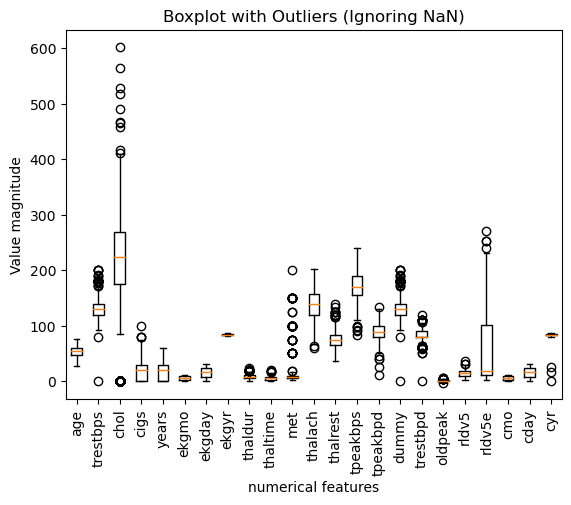

In [8]:
new_data_num = new_data[['age','trestbps', 'chol', 'cigs', 'years','ekgmo','ekgday','ekgyr', 'thaldur', 'thaltime', 'met', 'thalach', 'thalrest', 'tpeakbps', 'tpeakbpd', 'dummy', 'trestbpd', 'oldpeak', 'rldv5', 'rldv5e', 'cmo', 'cday', 'cyr']]
clean_data = [new_data_num[col].dropna() for col in new_data_num.columns]
plt.boxplot(clean_data, labels=new_data_num.columns)

# Show the plot
plt.title("Boxplot with Outliers (Ignoring NaN)")
plt.xticks(rotation=90)
plt.xlabel("numerical features")
plt.ylabel("Value magnitude")
plt.show()

Removing outliers by replacing it with common values by imputation methods talked about above. Also the NANs will be replaced by the methods described above.

In [9]:
def replace_outliers_iqr(column, factor=1.5):
    q1 = column.quantile(0.25)
    q3 = column.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - factor * iqr
    upper_bound = q3 + factor * iqr
    return column.where((column >= lower_bound) & (column <= upper_bound), float('nan'))
outliers_replaced = new_data_num.apply(lambda col: replace_outliers_iqr(col, factor=1.5))


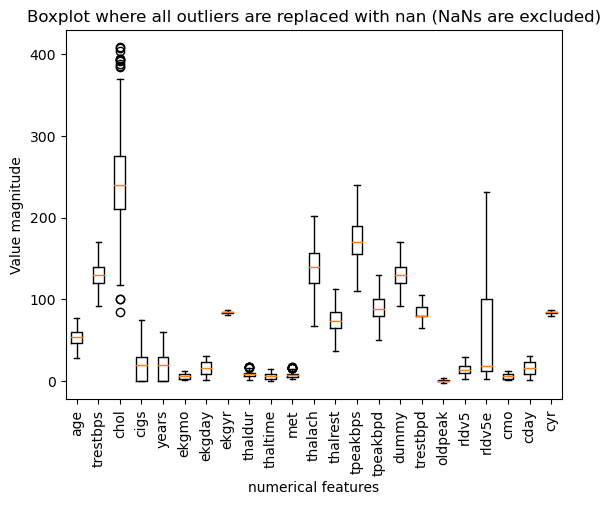

In [10]:
clean_data = [outliers_replaced[col].dropna() for col in outliers_replaced.columns]
plt.boxplot(clean_data, labels=outliers_replaced.columns)
# Show the plot
plt.title("Boxplot where all outliers are replaced with nan (NaNs are excluded)")
plt.xticks(rotation=90)
plt.xlabel("numerical features")
plt.ylabel("Value magnitude")
plt.show()

As seen above, the initial set of outliers from the raw data were removed and the dataset was re plotted. Now I will replace all nan values with the mean value of the non nans across each numerical data column.

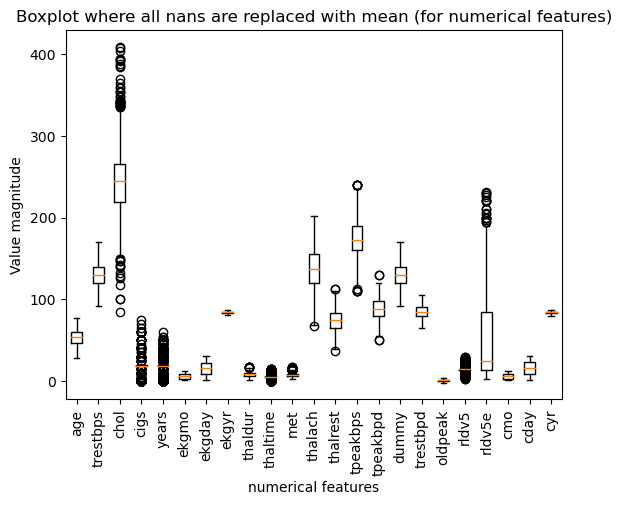

In [11]:
means = outliers_replaced.mean()
outliers_replaced.fillna(means, inplace = True)
plt.boxplot(outliers_replaced, labels=outliers_replaced.columns)
# Show the plot
plt.title("Boxplot where all nans are replaced with mean (for numerical features)")
plt.xticks(rotation=90)
plt.xlabel("numerical features")
plt.ylabel("Value magnitude")
plt.show()

The reason why there are still datapoints seemingly distant from the median even after correcting for outliers is because the data after the NaNs became replaced have their own outliers now because the concentration of data became more clustered around the mean.

Next, I will impute missing values for the categorical variables by replacing the nans with the mode class label

In [12]:
new_data_cat = new_data.drop(columns=['age','trestbps', 'chol', 'cigs', 'years','ekgmo','ekgday','ekgyr', 'thaldur', 'thaltime', 'met', 'thalach', 'thalrest', 'tpeakbps', 'tpeakbpd', 'dummy', 'trestbpd', 'oldpeak', 'rldv5', 'rldv5e', 'cmo', 'cday', 'cyr'])
threshold = 12

# Get the mode for proto with values below the threshold, ignoring NaN values
mode_below_threshold = new_data_cat[new_data_cat['proto'] < threshold]['proto'].mode().values[0]

# Replace values in proto above the threshold with the mode because in the documentation proto is only defined by a categorical var between 1-12
new_data_cat.loc[new_data_cat['proto'] > threshold, 'proto'] = mode_below_threshold

outlier = 22
mode_below_outlier = new_data_cat[new_data_cat['prop'] == outlier]['prop'].mode().values[0]

# Replace the invalid value in prop = 22 with the mode because in the documentation prop is supposed to be a categorical var between 0 - 1
new_data_cat.loc[new_data_cat['prop'] == outlier, 'prop'] = mode_below_threshold

# replace all NaNs across dataframe with mode of non NaN values for columns
# Define a function to get the mode, handling cases with multiple modes
def get_mode(series):
    # If the series contains NaN, return the first mode
    mode_series = series.mode()
    if not mode_series.empty:
        return mode_series.iloc[0]
    return None

# Loop through each column to check if it has NaN
for column in new_data_cat.columns:
    if new_data_cat[column].isnull().any():  # Check if there are NaN values in the column
        mode_value = get_mode(new_data_cat[column])  # Get the mode for the column
        if mode_value is not None:
            new_data_cat[column].fillna(mode_value, inplace=True)  # Fill NaN with the mode
new_data_cat = new_data_cat.astype(int)

# Check for columns where all values are either 0 or 1
is_boolean_col = (new_data_cat == 0) | (new_data_cat == 1)
columns_to_convert = new_data_cat.columns[is_boolean_col.all(axis=0)]

# Convert these columns to boolean
new_data_cat[columns_to_convert] = new_data_cat[columns_to_convert].astype(bool)

print(new_data_cat)

       sex  painloc  painexer  relrest  cp    htn    fbs  famhist  restecg  \
0     True     True      True     True   1   True   True     True        2   
1     True     True      True     True   4   True  False     True        2   
2     True     True      True     True   4   True  False     True        2   
3     True     True      True     True   3  False  False     True        0   
4    False     True      True     True   2   True  False     True        2   
..     ...      ...       ...      ...  ..    ...    ...      ...      ...   
894   True     True      True     True   4  False  False     True        0   
895   True     True      True     True   4  False   True     True        0   
896   True    False      True     True   3  False  False     True        0   
897   True     True      True     True   4  False  False     True        0   
898  False     True      True     True   4  False  False     True        0   

       dig  ...   nitr    pro  diuretic  proto  exang  xhypo  s

Recombining sub dataframes of numerical and categorical data

In [13]:
combined_data = pd.concat([outliers_replaced, new_data_cat], axis = 1)

Showing statistical measures of notable variables

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


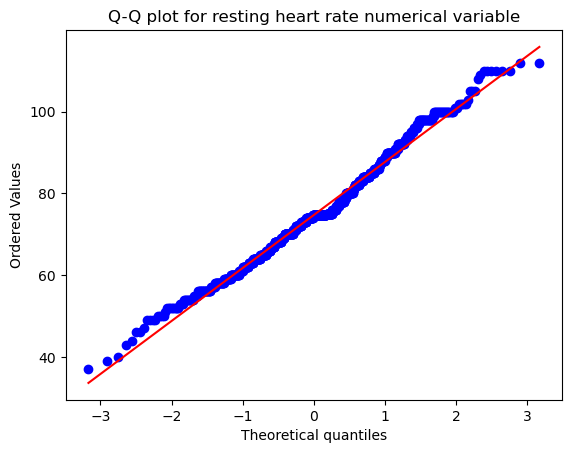

In [14]:
# Q-Q plot
probplot(combined_data['thalrest'], dist="norm", plot=plt)
plt.title('Q-Q plot for resting heart rate numerical variable')
plt.show()

From this Q-Q plot for resting heart rate ('thalrest'), we can see that this feature is roughly normally distributed as the datapoints lie closely on the red line

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


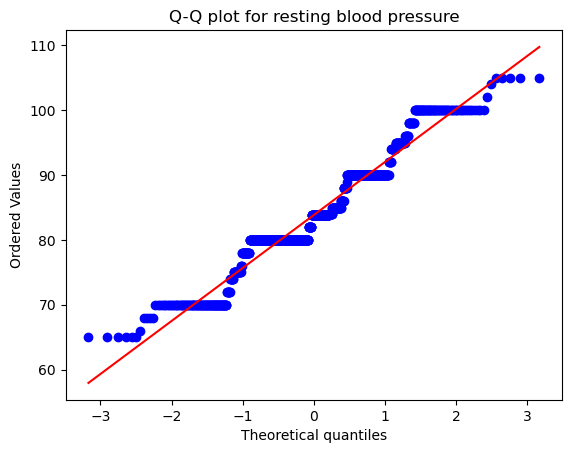

In [15]:
# Q-Q plot
probplot(combined_data['trestbpd'], dist="norm", plot=plt)
plt.title('Q-Q plot for resting blood pressure')
plt.show()

The reason why the Q-Q plot above for resting blood pressure shows a staircase pattern is because the data has discrete valeus or is rounded to certain levels, which blood pressure often is as its measured in whole numbers and units like mmHg.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


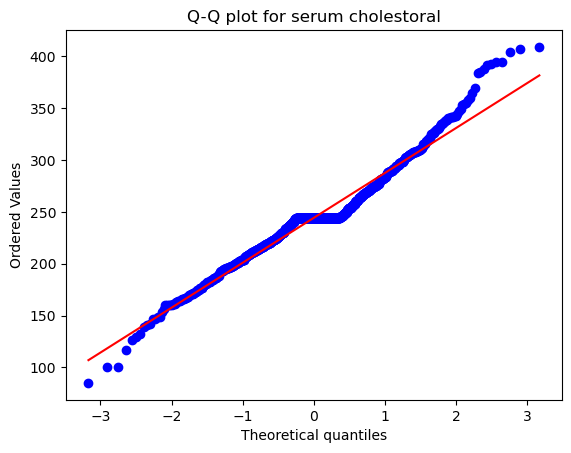

In [16]:
# Q-Q plot
probplot(combined_data['chol'], dist="norm", plot=plt)
plt.title('Q-Q plot for serum cholestoral')
plt.show()

The slight deviation at either ends might mean that there is some slight skewness in the serum cholesterol data. The distribution of serum cholesterol levels has heavier tails than the normal distribution

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


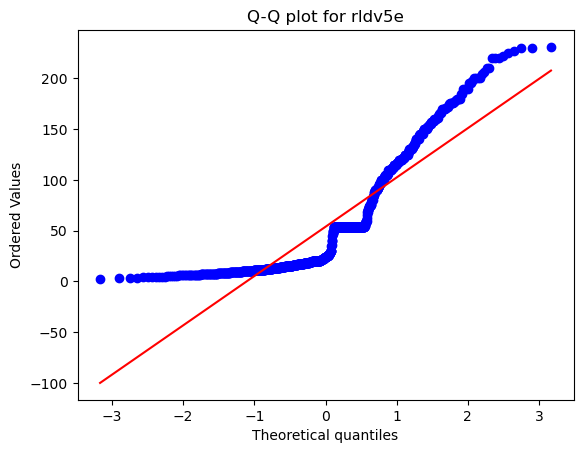

In [17]:
# Q-Q plot
probplot(combined_data['rldv5e'], dist="norm", plot=plt)
plt.title('Q-Q plot for rldv5e')
plt.show()

From this Q-Q plot of rldv5e, it seems like this feature doesn't follow a normal distribution due to the variation in the middle part of the plot as well as the significant upwards deviation in the two ends of the graph.

Feature Transformations

I will perform a feature transformation on the numerical rldv5e feature by using a logarithmic transformation to reduce skewness by compressing larger values to smaller ones.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


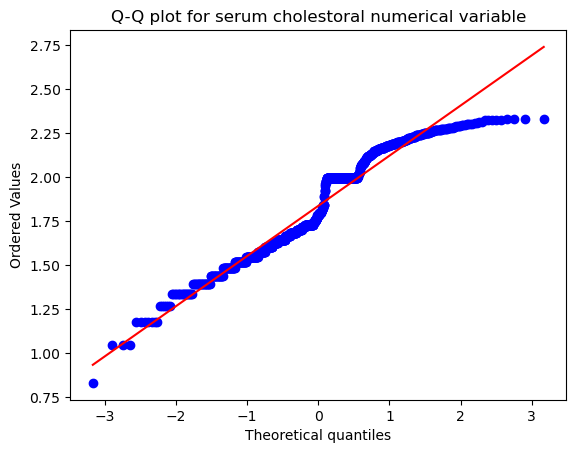

In [18]:
# Q-Q plot
probplot(np.power(np.log(combined_data['rldv5e']),0.5), dist="norm", plot=plt)
plt.title('Q-Q plot for serum cholestoral numerical variable')
plt.show()

From this Q-Q plot, the transformed feature is now more closely following the red line. The transformation applied was a natural log followed by a power to the 0.5 transformation. The log would help reduce the extremeties while the power to the 0.5 should assist reducing upward trend in the lower extremety.However, it is not perfect as the top end is trending downwards compared to the red line. But it is significantly better than the un transformed version so this transformed version will be used in place of the untransformed version.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


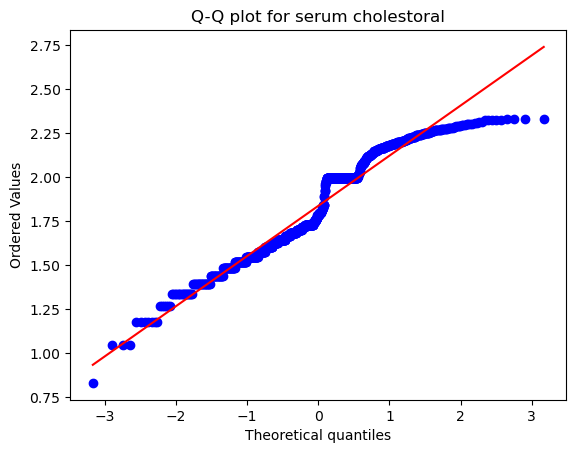

In [19]:
m= np.power(np.log(combined_data['rldv5e']),0.5)
combined_data['rldv5e'] = m
probplot(combined_data['rldv5e'], dist="norm", plot=plt)
plt.title('Q-Q plot for serum cholestoral')
plt.show()

Boxplot of a feature variable

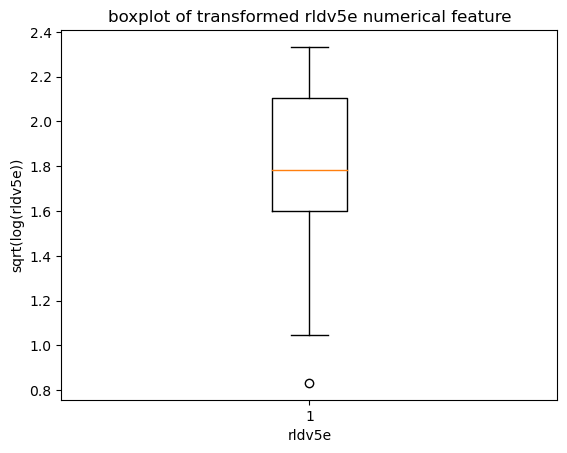

In [20]:
plt.boxplot(combined_data['rldv5e'])
plt.title('boxplot of transformed rldv5e numerical feature')
plt.ylabel('sqrt(log(rldv5e))')
plt.xlabel('rldv5e')
plt.show()

From this boxplot of the transformed feature rldv5e, the data data might be skewed towards the lower quartile because of the median line being closer to the bottom. The lower quartile also has a wider range of values compared to the upper quartile. The longer bottom whisker could also indicate the presence of outliers in the lower tail, in which there appears to be 1.

Scatterplot between age and cholestoral (both numerical data)

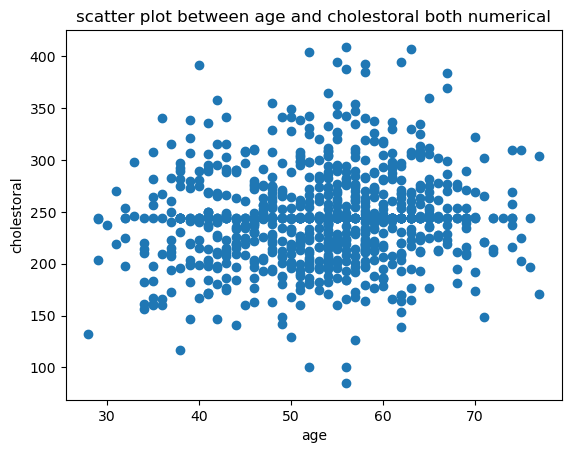

In [21]:
plt.scatter(combined_data['age'], combined_data['chol'])
plt.xlabel('age')
plt.ylabel('cholestoral')
plt.title('scatter plot between age and cholestoral both numerical')
plt.show()

From the above scatter plot between age and cholestoral, they appear to be rather uncorrelated as there is neither an upward nor a downward trend across the age groups

In [23]:
new_table_name = 'clean_table'
combined_data.to_sql(new_table_name, con=engine, if_exists='fail', index=False)
engine.dispose()